## Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:
* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* default - индикатор невозврата денежных средств

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy 
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = pd.read_csv('data\credit_card_default_analysis.csv', header=0)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.shape == data.dropna().shape # пропусков в данных нет

True

### Задание 1 Размер кредитного лимита (LIMIT_BAL)
В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   
a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  
b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения?

**1.** Выделим две группы вернувших (return_group) и не вернувших (default_group) людей для которых будем проверять гипотезы, построим распределения значений кредитного лимита для этих групп:

In [6]:
default_group = data[data.loc[:, 'default'] == 1]
return_group = data[data.loc[:, 'default'] == 0]

<AxesSubplot:title={'center':'LIMIT_BAL'}, xlabel='default'>

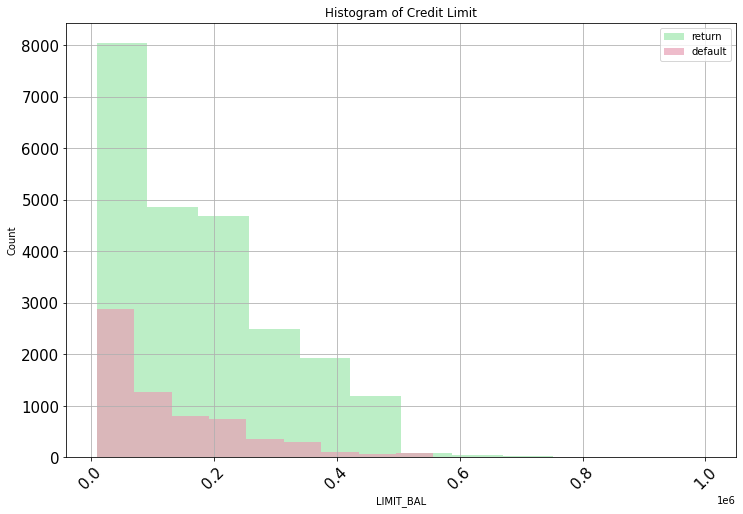

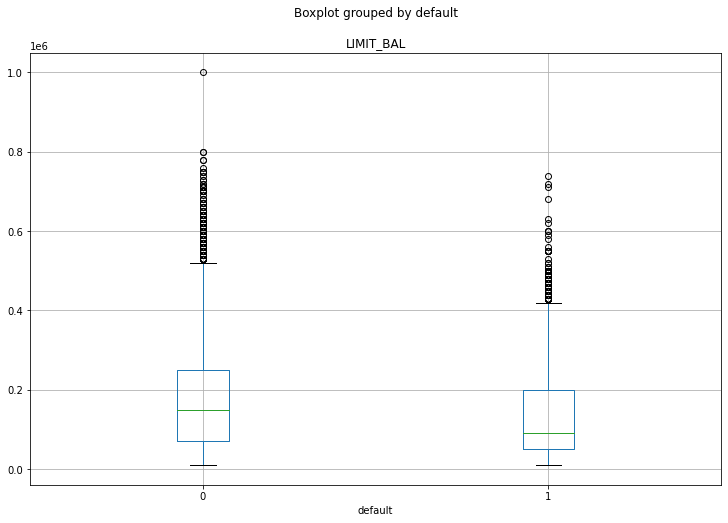

In [7]:
plt.figure(figsize=(12, 8))
return_group['LIMIT_BAL'].plot(kind='hist',
        label='return', 
        alpha=0.7,
        bins=12,
        rot=45,
        grid=True,
        fontsize=15, 
        color=['#A0E8AF'])
default_group['LIMIT_BAL'].plot(kind='hist',
        label='default', 
        alpha=0.7,
        bins=12,
        rot=45,
        grid=True,
        fontsize=15, 
        color=['#E8A0B5'])
plt.title('Histogram of Credit Limit')
plt.legend()
plt.xlabel('LIMIT_BAL')
plt.ylabel('Count')
plt.legend(['return', 'default'])

data.boxplot(column="LIMIT_BAL", by="default", figsize=(12, 8))

**Вывод:** По графику видно, что распределения схожи, но медианное значение кредитного лимита для людей, не вернувших кредит смещено в меньшую сторону.

**2.** Проверим гипотезу о равенстве медианных значений кредитного лимита методом bootstrap:

$H_0\colon$ медианы кредитного лимита для вернувших и не вернувших кредит совпадает

$H_1\colon$ медианы кредитного лимита отличаются

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

default_median_scores = np.array(list(map(np.median, get_bootstrap_samples(default_group['LIMIT_BAL'].values, 1000))))
return_median_scores = np.array(list(map(np.median, get_bootstrap_samples(return_group['LIMIT_BAL'].values, 1000))))

print("95% Доверительный интервал медианного значения кредитного лимита для выплтивших кредит:",  stat_intervals(return_median_scores, 0.05))
print("95% Доверительный интервал медианного значения кредитного лимита для не выплтивших кредит:",  stat_intervals(default_median_scores, 0.05))
print("95% Доверительный интервал для разностей медианного значения кредитного лимита:",  stat_intervals(return_median_scores - default_median_scores, 0.05))

95% Доверительный интервал медианного значения кредитного лимита для выплтивших кредит: [150000. 150000.]
95% Доверительный интервал медианного значения кредитного лимита для не выплтивших кредит: [80000. 90000.]
95% Доверительный интервал для разностей медианного значения кредитного лимита: [60000. 70000.]


**Вывод:** Доверительный интервал для разностей медианного значения кредитного лимита для двух групп далеко отстоит от нуля, можно с уверенностью говорить, что кредитный лимит для людей, выплативших кредит выше.

**3.** Проверим гипотезу о равенстве распределений кредитного лимита для людей, вернувших и не вернувших кредит. 

Очевидно, что выборки независимы, для проверки гипотезы о равенстве распределений из изученных критериев для этой задачи нам подходят критерий Уилкоксона — Манна — Уитни и двухвыборочный перестановочный критерий для независимых выборок. С учётом ограничений применимости критерия Уилкоксона — Манна — Уитни, а именно: 
1. *В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.* В данном случае различных значений признака больше 3х, это ограничение не актуально.
1. *В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).* В выборках много совпадающих значений, по этой причине применение этого критерия не целесообразно.

Проверим следующие гипотезу:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ распределения кредитного лимита для вернувших и не вернувших кредит совпадают  
против  
$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ распределения кредитного лимита для вернувших и невернувших кредит не совпадают

С помощью перестановочного критерия для независимых выборок:

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
p_value_credit = permutation_test(default_group['LIMIT_BAL'], return_group['LIMIT_BAL'], max_permutations=10000)
print(f'p-value: {round(p_value_credit, 4)}')

p-value: 0.0001


**Вывод:** Уровень значимости значительно меньше 0.05, нулевая гипотеза о равенстве средних отвергается в пользу альтернативы это доказывает, что банк предоставляет большие кредитные лимиты для людей, вернувших кредит.  

### Задание 2 Пол (SEX)
Проверьте гипотезу о том,  что гендерный состав  группы людей, вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

**1.** Посмотрим на гендерный состав в группах, выплативших и не выплативших кредит:

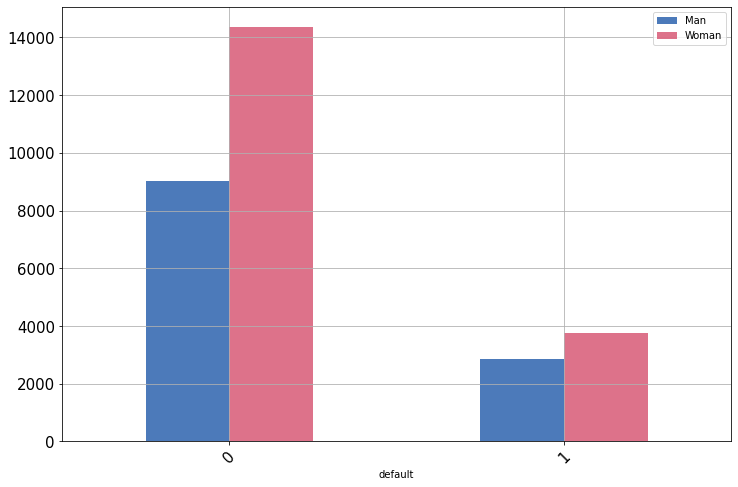

In [12]:
data.groupby(['default','SEX', ]).size().unstack().plot(
    kind='bar', 
    alpha=0.7,
    rot=45,
    grid=True,
    fontsize=15,
    figsize=(12, 8),
    color=['#00429d', '#cf3759'])
plt.legend(['Man', 'Woman'])

**Вывод:** По графику видно, что число женщин в обоих группах превосходит мужчин, но соотношение мужчин и женщин в двух группах несколько отличается, эту гипотезу необходимо проверить.

**2.** Для начала посмотрим на доверительные интервалы для доли мужчин ($SEX=1$) в двух группах:

In [13]:
conf_interval_default_m = proportion_confint(sum(default_group.loc[:, 'SEX'] == 1), 
                                            default_group.shape[0],
                                            method = 'wilson')
conf_interval_default_w = proportion_confint(sum(return_group.loc[:, 'SEX'] == 1), 
                                            return_group.shape[0],
                                            method = 'wilson')

In [14]:
print("95% Доверительный интервал мужчин в группе не вернувших кредит:",  
      np.round(conf_interval_default_m, 4))
print("95% Доверительный интервал мужчин в группе вернувших кредит:",  
      np.round(conf_interval_default_w, 4))

95% Доверительный интервал мужчин в группе не вернувших кредит: [0.4211 0.4449]
95% Доверительный интервал мужчин в группе вернувших кредит: [0.3796 0.3921]


**Вывод:** Интервалы положительные и не пересекаются, уже можно заключить, гендерный состав для двух групп не одинаков.

**3.** Посмотрим на доверительный интервал для разности долей мужчин группах вернувших и не вернувших кредит:

In [15]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = np.sum(sample1 == 1)/len(sample1)
    p2 = np.sum(sample2 == 1)/len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [16]:
print("95% Доверительный интервал для разности долей мужчин в группах вернувших и не вернувших кредит:",  
      np.round(
          proportions_diff_confint_ind(
              default_group['SEX'],
              return_group['SEX']),
          4))

95% Доверительный интервал для разности долей мужчин в группах вернувших и не вернувших кредит: [0.0336 0.0605]


**Вывод:** Интервал не содержит нуля и положительный, что подтверждает нашу гипотезу о различном гендерном составе двух групп.

**4.** Посчитаем достигаемый уровень значимости и проверим гипотезу:

$H_0\colon$ гендерный состав одинаков для двух групп  
против альтернативы  
$H_1\colon$ гендерный состав различается

In [17]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = np.sum(sample1) / n1
    p2 = np.sum(sample2) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(sample1, sample2, alternative = 'two-sided'):
    z_stat = proportions_diff_z_stat_ind(sample1, sample2)
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [18]:
print("Достигаемый уровень значимости:",  
      proportions_diff_z_test(
          default_group['SEX'] == 1,
          return_group['SEX'] == 1)
          )

Достигаемый уровень значимости: 4.472866521609831e-12


**Вывод:** Достигаемый уровень значимости ≪ 0.05 гипотеза о равенстве гендерного состава отвергается.

### Задание 3 Образование (EDUCATION)
Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек, вернувших и не вернувших долг.

Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу, не потеряв в интерпретируемости?

Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг? наоборт, не отдаст долг ?

**1.** Первым делом посмотрим как распределены люди вернувшие и не вернувшие кредит в зависимости от их образования и так как количество людей в разных группах сильно отличается нормируем их к общему число людей с соответствующим образованием:

In [19]:
education_default_table = data.groupby(
    ['EDUCATION', 'default']).count().unstack()['ID'].fillna(0)
education_default_table

default,0,1
EDUCATION,,
0,14.0,0.0
1,8549.0,2036.0
2,10700.0,3330.0
3,3680.0,1237.0
4,116.0,7.0
5,262.0,18.0
6,43.0,8.0


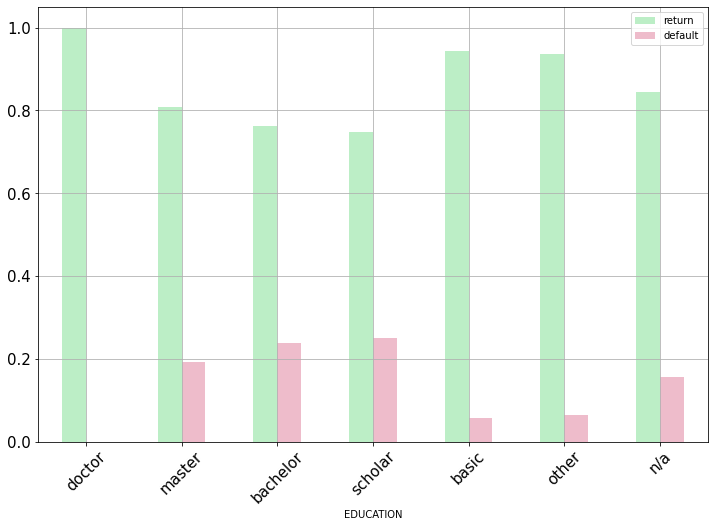

In [20]:
ax = education_default_table.apply(lambda x: x/sum(x), axis=1).plot(
    kind='bar',
    alpha=0.7,
    rot=45,
    grid=True,
    fontsize=15,
    figsize=(12, 8),
    color=['#A0E8AF','#E8A0B5'])
ax.legend(['return', 'default'])
ax.set_xticklabels(['doctor','master','bachelor','scholar','basic','other','n/a']);

**2.** Так как данные категориальные, для того чтобы понять, есть ли между ними взаимосвязь для полученной таблице сопряжённости (education_default_table) можно посчитать коэффициент V-Крамера и найти значение критерия $\chi^2$. Тем самым проверить гипотезу:

$H_0\colon$ образование не влияет на то, вернет ли человек долг  
против альтернативы  
$H_1\colon$ образование влияет на то, вернет ли человек долг  

Однако, сначала необходимо проверить выполняются ли условия применения критерия $\chi^2$ для полученной таблицы сопряженности, a именно:  
1. Выборки должны быть достаточно большими: n ≥ 40;
1. Ожидаемое количество элементов в каждой ячейке таблицы было меньше 5, не более, чем в 20% ячеек

In [21]:
print(f'Общее количество элементов: {np.sum(education_default_table.values)} > 40')
count_cell_less_5_per = lambda x: np.sum(x < 5) * 100 / x.size
print(f'% ячейек таблицы с количеством элементов меньше 5: {count_cell_less_5_per(education_default_table.values)}% < 20 ')

Общее количество элементов: 30000.0 > 40
% ячейек таблицы с количеством элементов меньше 5: 7.142857142857143% < 20 


In [22]:
def v_Cramer_correlation(table):
    chi_stat = stats.chi2_contingency(table)[0]
    k_min = np.min(table.shape)
    n = np.sum(table)
    return np.sqrt(chi_stat/(n*(k_min-1)))

print('Коэффициент V-Крамера: ',
      v_Cramer_correlation(education_default_table.values))
print('Значение хи-квадрат: ',
      stats.chi2_contingency(education_default_table.values)[1])

Коэффициент V-Крамера:  0.07376009713252163
Значение хи-квадрат:  1.2332626245415605e-32


**Вывод:** Коэффициент V-Крамера отличен от нуля, критерий $\chi^2$ подтверждает, что это отличие статистически значимо. Небольшое значение говорит о том, что влияние образования на возврат или не возрат кредита есть, но оно слабое. По графику видно, что наличие докторской степени является индикатором того, что человек отдаст кредит, а самый большой процент невозврата наблюдается у людей со средним образованием.    

### Задание 4 Семейное положение (MARRIAGE)
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

**1.** По аналогии с предыдущим заданием посмотрим как распределены люди вернувшие и не вернувшие кредит в зависимости от их семейного положения и так как количество людей в разных группах сильно отличается нормируем их к общему число людей с соответствующим образованием:

In [23]:
marriage_default_table = data.groupby(
    ['MARRIAGE', 'default']).count().unstack()['ID'].fillna(0)
marriage_default_table

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


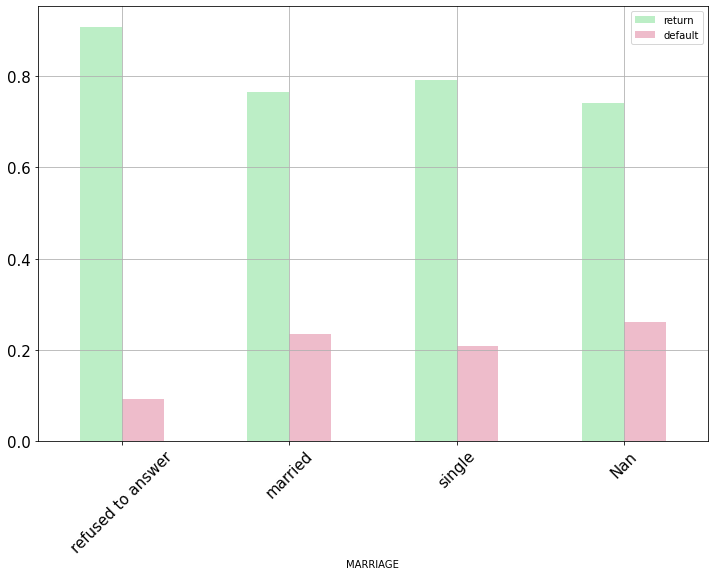

In [24]:
ax = marriage_default_table.apply(lambda x: x/sum(x), axis=1).plot(
    kind='bar',
    alpha=0.7,
    rot=45,
    grid=True,
    fontsize=15,
    figsize=(12, 8),
    color=['#A0E8AF','#E8A0B5'])
ax.legend(['return', 'default'])
ax.set_xticklabels(['refused to answer','married','single','Nan']);

**2.** Так как данные категориальные, для того чтобы понять, есть ли между ними взаимосвязь для полученной таблице сопряжённости (marriage_default_table) можно посчитать коэффициент V-Крамера и найти значение критерия $\chi^2$. Тем самым проверить гипотезу:

$H_0\colon$ семейное положение не влияет на то, вернет ли человек долг  
против альтернативы  
$H_1\colon$ семейное положение влияет на то, вернет ли человек долг  

Однако, сначала необходимо проверить выполняются ли условия применения критерия $\chi^2$ для полученной таблицы сопряженности, a именно:  
1. Выборки должны быть достаточно большими: n ≥ 40;
1. Ожидаемое количество элементов в каждой ячейке таблицы было меньше 5, не более, чем в 20% ячеек

In [25]:
print(f'Общее количество элементов: {np.sum(marriage_default_table.values)} > 40')
count_cell_less_5_per = lambda x: np.sum(x < 5) * 100 / x.size
print(f'% ячейек таблицы с количеством элементов меньше 5: {count_cell_less_5_per(marriage_default_table.values)}% < 20 ')

Общее количество элементов: 30000 > 40
% ячейек таблицы с количеством элементов меньше 5: 0.0% < 20 


In [26]:
def v_Cramer_correlation(table):
    chi_stat = stats.chi2_contingency(table)[0]
    k_min = np.min(table.shape)
    n = np.sum(table)
    return np.sqrt(chi_stat/(n*(k_min-1)))

print('Коэффициент V-Крамера: ',
      v_Cramer_correlation(marriage_default_table.values))
print('Значение хи-квадрат: ',
      stats.chi2_contingency(marriage_default_table.values)[1])

Коэффициент V-Крамера:  0.034478203662766466
Значение хи-квадрат:  8.825862457577375e-08


**Вывод:** Коэффициент V-Крамера отличен от нуля, критерий $\chi^2$ подтверждает, что это отличие статистически значимо. Небольшое значение говорит о том, что семейного положения на возврат или не возврат кредита есть, но оно крайне слабое.

### Задание 5 Возраст (AGE)
Относительно двух групп людей  вернувших и не вернувших, кредит проверьте следующие гипотезы:

a) о равенстве медианных значений возрастов людей

b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

<AxesSubplot:title={'center':'AGE'}, xlabel='default'>

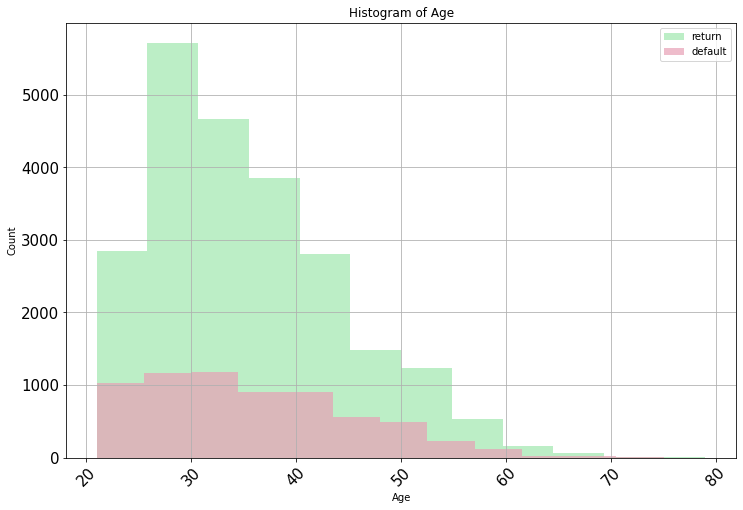

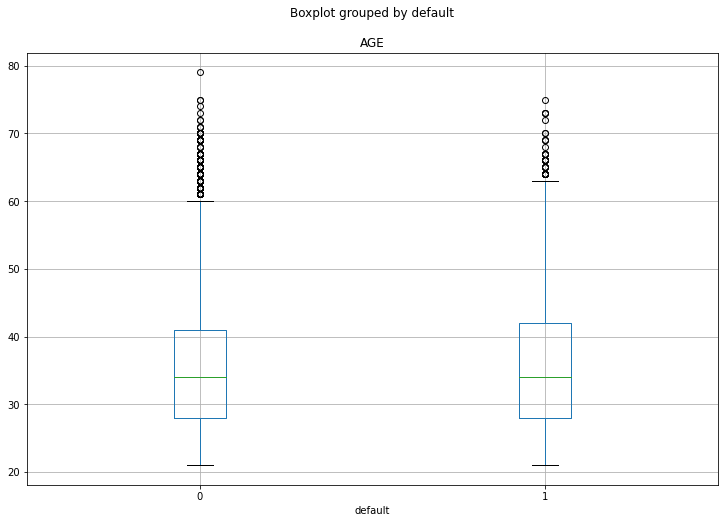

In [27]:
plt.figure(figsize=(12, 8))
return_group['AGE'].plot(kind='hist',
        label='return', 
        alpha=0.7,
        bins=12,
        rot=45,
        grid=True,
        fontsize=15, 
        color=['#A0E8AF'])
default_group['AGE'].plot(kind='hist',
        label='default', 
        alpha=0.7,
        bins=12,
        rot=45,
        grid=True,
        fontsize=15, 
        color=['#E8A0B5'])
plt.title('Histogram of Age')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(['return', 'default'])


data.boxplot(column="AGE", by="default", figsize=(12, 8))

**Вывод:** По графику видно, что распределения схожи и медианные значения возраста в двух группах практически одинаково.

**2.** Проверим гипотезу о равенстве медианных значений возраста методом bootstrap:

$H_0\colon$ медианы возраста для вернувших и не вернувших кредит совпадает

$H_1\colon$ медианы возраста отличаются

In [28]:
np.random.seed(0)

default_median_age_scores = np.array(list(map(np.median, get_bootstrap_samples(default_group['AGE'].values, 1000))))
return_median_age_scores = np.array(list(map(np.median, get_bootstrap_samples(return_group['AGE'].values, 1000))))

print("95% Доверительный интервал медианного значения возраста для выплативших  кредит:",  stat_intervals(return_median_age_scores, 0.05))
print("95% Доверительный интервал медианного значения возраста для не выплативших  кредит:",  stat_intervals(default_median_age_scores, 0.05))
print("95% Доверительный интервал для разностей медианного значения возраста:",  stat_intervals(return_median_age_scores - default_median_age_scores, 0.05))

95% Доверительный интервал медианного значения возраста для выплативших  кредит: [34. 34.]
95% Доверительный интервал медианного значения возраста для не выплативших  кредит: [34. 35.]
95% Доверительный интервал для разностей медианного значения возраста: [-1.  0.]


**Вывод:** Доверительный интервал для разностей медианного возраста содержит ноль, гипотеза о том, что медианы возраста для вернувших и не вернувших кредит совпадает не отвергается.

**3.** Проверим следующие гипотезы :

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ распределения возраста для вернувших и не вернувших кредит совпадает

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ распределения возраста для вернувших и не вернувших кредит не совпадает

С помощью перестановочного критерия для независимых выборок:

In [29]:
p_value_age = permutation_test(
    default_group['AGE'].fillna(0).values,
    return_group['AGE'].fillna(0).values,
    max_permutations=1000)
print(f'p-value: {round(p_value_age, 4)}')

p-value: 0.024


**Вывод:** Уровень значимости несколько меньше 0.05, нулевая гипотеза о равенстве распределений отвергается в пользу альтернативы это доказывает, что возраст человека влияет на то вернёт он кредит или нет. По графику можно заметить, что молодыек люди < 30 лет склонны чаще не возращать кредит.  

### Заключение:
Проанализировав данные, полученные из кредитных историй клиентов одного из банков, были получены следующие выводы:
1. Размер кредитного лимита, для людей выплативших кредит значимо выше;
1. Гендерный состав группы, людей вернувших и не вернувших кредит статистически значимо отличается;
1. Образование статистически значимо влияет на вероятность дефолта, хоть и не очень сильно;
1. Семейное положение очень слабо, но статистически значимо влияет на вероятность возврата кредита;
1. Возрастной состав в группах, вернувших и не вернувших кредит статистически значимо отличается.

Рассмотренные признаки стоит учитывать при выдаче кредитов, но всё же главными признаками являются не рассмотренные в этом исследовании, доход и стабильное трудоустройство клиента.